In this file, we amplitude encode nouns represented by four dimensional vectors in classical vector spaces onto Hilbert spaces spanned by two qubits. 

We use three different models for the QNLP workflow:
    - Numpy model 
    - Tket model 
    - Pennylane model 

And we use different methods of amplitude encoding:
    - Encoding of Wikipedia2Vec 
    - Encoding of Naive assumption 
    - Encoding of Baseline (all nouns initialized to |00>)

In [26]:
# Import all kinds of lambeq stuff 
from lambeq.backend.grammar import (Box, Cap, Cup, Diagram, Diagrammable,
                                    Functor, grammar, Id, Spider, Swap,
                                    Ty, Word)
from lambeq.backend.drawing import draw
import matplotlib.pyplot as plt
import matplotlib
from lambeq import AtomicType

# optimising the diagram to make the resulting quanutm circuit less complex
from lambeq import RemoveSwapsRewriter, RemoveCupsRewriter
from lambeq import Rewriter 

# creating the quantum circuit
from lambeq import IQPAnsatz
from pytket.extensions.qiskit import tk_to_qiskit

import numpy as np

# amplitude Encoding
from qiskit import QuantumCircuit

In [27]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 100
LEARNING_RATE = 3e-2
SEED = 2

In [28]:

# load training data 

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, forget  = read_data('../datasets/mc_train_data.txt')
test_labels, forget = read_data('../datasets/mc_test_data.txt')
val_labels, forget = read_data('../datasets/mc_dev_data.txt')


# here, we can choose between either the original dataset by Coecke et al. or the new one for Gijs' data

gijs = False

if not gijs: 
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/newTestSentences.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/newTrainSentences.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/newValSentences.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]


if gijs:
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/testGijs.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/trainGijs.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/valGijs.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]


In [29]:
# parse sentences from data to diagrams 

from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


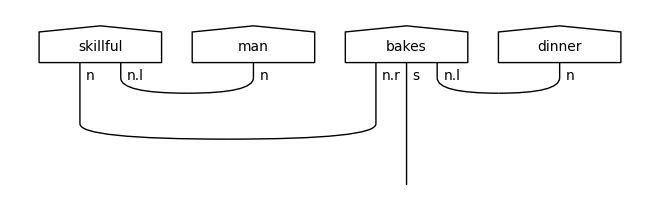

In [30]:
raw_train_diagrams[1].draw()

In [31]:
# normalising by removing cups 

from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_val_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]



In [32]:
'''
This is new when amplitude encoding: 

we include the dictionary indicating what four dimensional word vector to use for what word 

'''

import json

# wiki2vec
with open("../datasets/newNounVectorsPCA.json", 'r') as fp:
    parameterDict = json.load(fp)

# extreme encodes all words to two extreme sides of the bloch sphere 
# with open("../datasets/extremeNounVectors.json", 'r') as fp:
#     parameterDict = json.load(fp)

# trivial encodes all words to [0,0,0,0]
# with open("../datasets/trivialNounVectors.json", 'r') as fp:
#     parameterDict = json.load(fp)
#

# NQ = 2

# # in the case of one qubit, the parameter dict is simply: 
# if NQ == 1:
#     parameterDict = {}
#     parameterDict['woman'] = np.pi/2
#     parameterDict['man'] = np.pi/2
#     parameterDict['person'] = np.pi/2
#     parameterDict['meal'] = 0
#     parameterDict['dinner'] = 0
#     parameterDict['sauce'] = 0
#     parameterDict['program'] = np.pi
#     parameterDict['application'] = np.pi
#     parameterDict['software'] = np.pi



In [33]:

# GIJS = True  

# naiveSentences = ['person prepares meal', 'person cooks meal', 'person bakes meal', 'person reads meal', 'person runs meal'
#                 'person prepares dinner', 'person cooks dinner', 'person bakes dinner', 'person reads dinner', 'person runs dinner',
#                 'person prepares sauce', 'person cooks sauce', 'person bakes sauce', 'person reads sauce', 'person runs sauce',
#                 'person prepares program', 'person cooks program', 'person bakes program', 'person reads program', 'person runs program',
#                 'person prepares software', 'person cooks software', 'person bakes software', 'person reads software', 'person runs software',
#                 'person prepares application', 'person cooks application', 'person bakes application', 'person reads application', 'person runs application',
#                 ]





# if not GIJS: 

#     senseFulSentences = ['person prepares meal', 'person cooks meal', 'person bakes meal',
#                     'person prepares dinner', 'person cooks dinner', 'person bakes dinner',
#                     'person prepares sauce', 'person cooks sauce', 'person bakes sauce',
#                     'person prepares program', 'person reads program', 'person runs program',
#                     'person prepares software', 'person reads software', 'person runs software',
#                     'person prepares application', 'person reads application', 'person runs application',
#                     'man prepares meal', 'man cooks meal', 'man bakes meal',
#                     'man prepares dinner', 'man cooks dinner', 'man bakes dinner',
#                     'man prepares sauce', 'man cooks sauce', 'man bakes sauce',
#                     'man prepares program', 'man reads program', 'man runs program',
#                     'man prepares software', 'man reads software', 'man runs software',
#                     'man prepares application', 'man reads application', 'man runs application',
#                     'woman prepares meal', 'woman cooks meal', 'woman bakes meal',
#                     'woman prepares dinner', 'woman cooks dinner', 'woman bakes dinner',
#                     'woman prepares sauce', 'woman cooks sauce', 'woman bakes sauce',
#                     'woman prepares program', 'woman reads program', 'woman runs program',
#                     'woman prepares software', 'woman reads software', 'woman runs software',
#                     'woman prepares application', 'woman reads application', 'woman runs application',
#                     ]
    
#     mySentences = ['person prepares meal and cooks it', 'person prepares meal and bakes it', 'person prepares meal and reads it', 'person prepares meal and runs it',
#                     'man prepares meal and cooks it', 'man prepares meal and bakes it', 'man prepares meal and reads it', 'man prepares meal and runs it',
#                     'woman prepares meal and cooks it', 'woman prepares meal and bakes it', 'woman prepares meal and reads it', 'woman prepares meal and runs it']


# # gijs doesn't know words man, woman 
# if GIJS:
#     senseFulSentences = ['person prepares meal', 'person cooks meal', 'person bakes meal',
#                     'person prepares dinner', 'person cooks dinner', 'person bakes dinner',
#                     'person prepares sauce', 'person cooks sauce', 'person bakes sauce',
#                     'person prepares program', 'person reads program', 'person runs program',
#                     'person prepares software', 'person reads software', 'person runs software',
#                     'person prepares application', 'person reads application', 'person runs application'
#                     ]



#     mySentences = ['person prepares meal and cooks it', 'person prepares meal and bakes it', 'person prepares meal and reads it', 'person prepares meal and runs it']




# # we disambiguate the first sentence using the second one 
# gijsSentences = ['person prepares meal and chef does too', 'person prepares meal and programmer does too', 'person prepares meal and person does too']



# naiveCircuits = []
# gijsCircuits  = []
# myCircuits    = []


# for nS in senseFulSentences: 
#     naiveCircuits.append(NaiveDiag(nS))

# for gS in gijsSentences: 
#     gijsCircuits.append(GijsDiag(gS))

# for mS in mySentences: 
#     myCircuits.append(AmbiguousVerb(mS))




The number of noun parameters does not fit the number of single qubit operators. 
params in circuitfunction: [[man__n_0]]
thetas:  [man__n_0]
we have to do somehting
the word is:   man
is it daggered?  False
and the parameters are:  [-0.04641067895771134, 0.919485873505192, 0.32529162382451876, -0.2158173690245671]
vector to amplitude encode:  [-0.04641068  0.91948587  0.32529162 -0.21581737]
params in circuitfunction: [[prepares__n.r@s@n.l_0 prepares__n.r@s@n.l_1 prepares__n.r@s@n.l_2
  prepares__n.r@s@n.l_3]]
thetas:  [prepares__n.r@s@n.l_0 prepares__n.r@s@n.l_1 prepares__n.r@s@n.l_2
 prepares__n.r@s@n.l_3]
params in circuitfunction: [[sauce†_n__0]]
thetas:  [sauce†_n__0]
we have to do somehting
the word is:   sauce
is it daggered?  True
and the parameters are:  [0.7496800847924793, -0.4649412402578309, 0.41714562135555733, -0.21862969642053917]
vector to amplitude encode:  [ 0.74968008 -0.46494124  0.41714562 -0.2186297 ]
params in circuitfunction: [[skillful†_n@n.l__0 skillful†_n@n

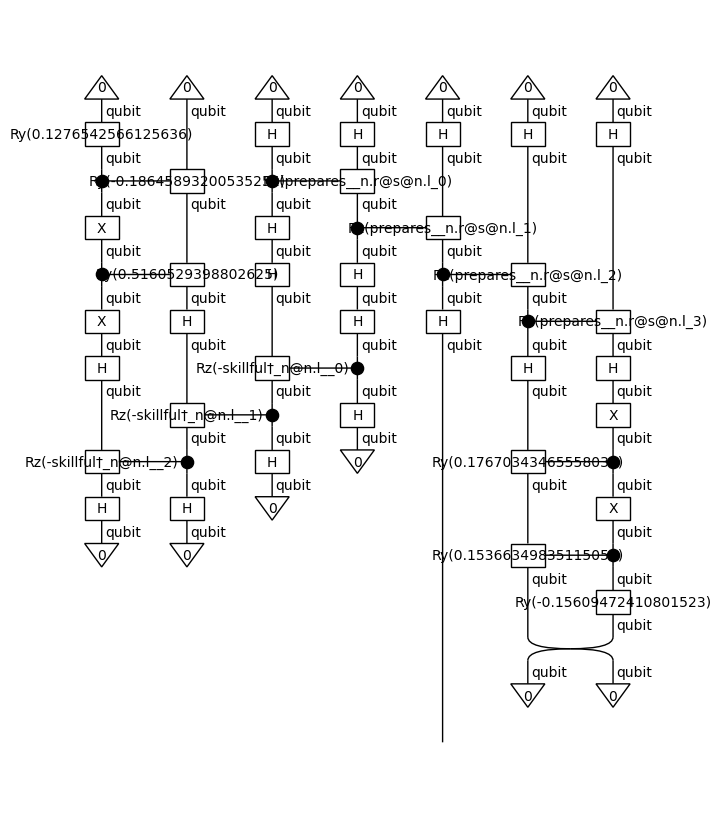

In [34]:
# create quantum circuits using the amplitude encoding ansatz

from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

# replace the naive way of encoding with the amplitude encoding Code developed in the file IQPAmplitudeEncoding.py 
from IQPAmplitudeEncode import * 

# the corresponding function is IQPAmplitudeEncode2QB
ansatz = IQPAmplitudeEncode2QB({AtomicType.NOUN: 2, AtomicType.SENTENCE: 1},
                   n_layers=1, nounParams=np.array([1,2,3,4, 1,2,3,4,]), parameterDict=parameterDict, n_single_qubit_params=3)

# from IQPAmplitudeEncode_1QB import *
# ansatz = IQPAmplitudeEncode({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
#                    n_layers=1, nounParams=np.array([1,2,3,4, 1,2,3,4,]), n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

First model: Pennylane 

In [35]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + val_circuits + test_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
modelPennylane = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
modelPennylane.initialise_weights()



In [36]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)
                          
val_dataset = Dataset(val_circuits, val_labels)

In [37]:
def accPL(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

In [38]:
from lambeq import PytorchTrainer
import torch

trainerPennylane = PytorchTrainer(
    model=modelPennylane,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': accPL},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

In [39]:
# trainer.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

trainerPennylane.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 0.2121   valid/loss: 0.2436   train/acc: 0.5286   valid/acc: 0.6667
Epoch 2:    train/loss: 0.2534   valid/loss: 0.2103   train/acc: 0.6857   valid/acc: 0.7333
Epoch 3:    train/loss: 0.1591   valid/loss: 0.2094   train/acc: 0.6714   valid/acc: 0.7333
Epoch 4:    train/loss: 0.2785   valid/loss: 0.1957   train/acc: 0.7143   valid/acc: 0.7333
Epoch 5:    train/loss: 0.0714   valid/loss: 0.1502   train/acc: 0.8000   valid/acc: 0.8333
Epoch 6:    train/loss: 0.2774   valid/loss: 0.1411   train/acc: 0.8143   valid/acc: 0.8000
Epoch 7:    train/loss: 0.0592   valid/loss: 0.1263   train/acc: 0.8571   valid/acc: 0.8667
Epoch 8:    train/loss: 0.1411   valid/loss: 0.1158   train/acc: 0.8429   valid/acc: 0.8000
Epoch 9:    train/loss: 0.0884   valid/loss: 0.0989   train/acc: 0.9000   valid/acc: 0.8333
Epoch 10:   train/loss: 0.0469   valid/loss: 0.0676   train/acc: 0.9286   valid/acc: 0.9667
Epoch 11:   train/loss: 0.0874   valid/loss: 0.0593   train/acc: 0.9714   valid/

Second model: Numpy 

In [40]:
# Do the same thing, but now using the NUMPY model! 

from lambeq import NumpyModel

modelNumpy = NumpyModel.from_diagrams(all_circuits, use_jit=False)


from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

accNP = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": accNP}


# NUMPY model uses QuantumTrainer class 

from lambeq import QuantumTrainer, SPSAOptimizer

trainerNumpy = QuantumTrainer(
    modelNumpy,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)




In [41]:
# train the numpy model 

trainerNumpy.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 0.3780   valid/loss: 0.6530   train/acc: 0.6714   valid/acc: 0.6667


Epoch 2:    train/loss: 0.8409   valid/loss: 0.7128   train/acc: 0.6714   valid/acc: 0.6000
Epoch 3:    train/loss: 0.4570   valid/loss: 0.6194   train/acc: 0.6143   valid/acc: 0.6000
Epoch 4:    train/loss: 0.8919   valid/loss: 0.6157   train/acc: 0.6571   valid/acc: 0.6333
Epoch 5:    train/loss: 0.8544   valid/loss: 0.6070   train/acc: 0.6429   valid/acc: 0.6333
Epoch 6:    train/loss: 0.5614   valid/loss: 0.5977   train/acc: 0.6714   valid/acc: 0.6000
Epoch 7:    train/loss: 0.6536   valid/loss: 0.5674   train/acc: 0.6429   valid/acc: 0.6333
Epoch 8:    train/loss: 0.5009   valid/loss: 0.5192   train/acc: 0.6857   valid/acc: 0.7333
Epoch 9:    train/loss: 0.6814   valid/loss: 0.5850   train/acc: 0.7714   valid/acc: 0.7667
Epoch 10:   train/loss: 0.3190   valid/loss: 0.5096   train/acc: 0.7143   valid/acc: 0.8000
Epoch 11:   train/loss: 0.5183   valid/loss: 0.4850   train/acc: 0.8000   valid/acc: 0.8667
Epoch 12:   train/loss: 0.3210   valid/loss: 0.5175   train/acc: 0.8286   valid/

Third model: Tket 

In [42]:
'''
Same thing, but for Tket model 
'''

from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

modelTK = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bceTK = BinaryCrossEntropyLoss()

accTK = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metricsTK = {"acc": accTK}

from lambeq import QuantumTrainer, SPSAOptimizer

trainerTK = QuantumTrainer(
    modelTK,
    loss_function=bceTK,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metricsTK,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)


trainerTK.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

Epoch 1:    train/loss: 1.4823   valid/loss: 0.8891   train/acc: 0.4786   valid/acc: 0.5500
Epoch 2:    train/loss: 2.6377   valid/loss: 1.3603   train/acc: 0.6286   valid/acc: 0.6000
Epoch 3:    train/loss: 6.0310   valid/loss: 2.9283   train/acc: 0.4500   valid/acc: 0.4000
Epoch 4:    train/loss: 7.4005   valid/loss: 1.7300   train/acc: 0.3214   valid/acc: 0.4167
Epoch 5:    train/loss: 3.8785   valid/loss: 2.1187   train/acc: 0.3857   valid/acc: 0.6000
Epoch 6:    train/loss: 2.9200   valid/loss: 1.4971   train/acc: 0.5000   valid/acc: 0.5833
Epoch 7:    train/loss: 2.1118   valid/loss: 2.9303   train/acc: 0.4857   valid/acc: 0.5500
Epoch 8:    train/loss: 6.6310   valid/loss: 2.9521   train/acc: 0.4643   valid/acc: 0.4000
Epoch 9:    train/loss: 0.5758   valid/loss: 1.3367   train/acc: 0.5714   valid/acc: 0.6500
Epoch 10:   train/loss: 4.7359   valid/loss: 3.2418   train/acc: 0.6786   valid/acc: 0.6667
Epoch 11:   train/loss: 1.0277   valid/loss: 1.5155   train/acc: 0.5429   valid/

In [43]:
'''
Before we look at the results of the training, let us understand what exactly these circuits are that we trained above. 

We start by extracting the parameters for the symbols learned by Coecke et al. 


'''

# The symbols are the names of the respective parameters for the respective words
smbls = modelNumpy.symbols

# And the weights are their respective values 
weights = modelNumpy.weights

# create a simple dictionary for parameters and weights 
parameterDict = {}
for i in range(len(smbls)):
    parameterDict[str(smbls[i])] = weights[i].item()


import pickle

with open('../weights/weightsDict_NP_2QB_AE_100.pkl', 'wb') as fp:
    pickle.dump(parameterDict, fp)



Final test accuracy: 1.0
Validation accuracy: 0.5833333333333334


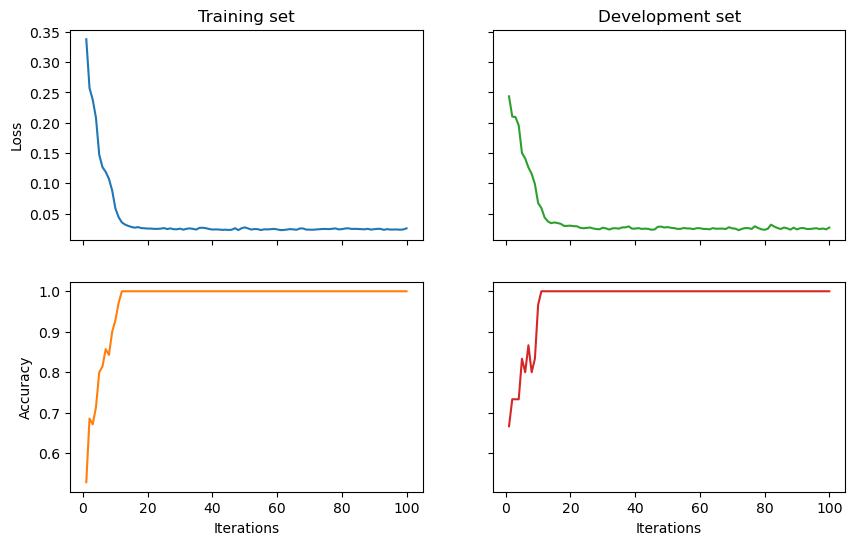

In [44]:
'''
Performance of the model!! 
'''


import matplotlib.pyplot as plt

trainer = trainerPennylane
model = modelPennylane
acc = accPL
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

# print test accuracy - tket
modelTK.load(trainerTK.log_dir + '/best_model.lt')
val_acc = accTK(modelTK(test_circuits), test_labels)
print('Validation accuracy:', val_acc.item())

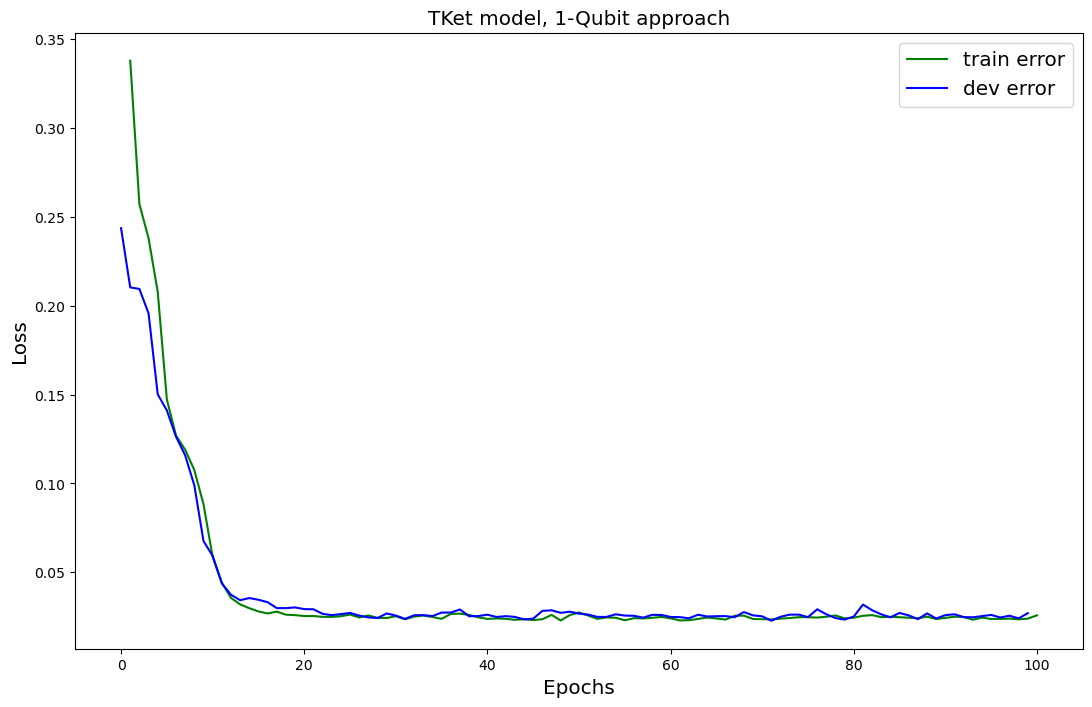

In [45]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots(figsize=(13, 8))

# ax1.plot(range_, trainer.train_epoch_costs, '-k', markersize=4, label='cost')
ax1.plot(range_, trainer.train_epoch_costs, '-g', markersize=4, label='train error')
ax1.plot(range(len(trainer.val_costs)), trainer.val_costs, '-b', markersize=4, label='dev error')
ax1.set_ylabel(r"Loss", fontsize='x-large')
ax1.set_xlabel(r"Epochs", fontsize='x-large')
# ax1.legend(loc='upper center', fontsize='x-large')

# ax2 = ax1.twinx()
# ax2.set_ylabel(r"Error in \%", fontsize='x-large')
# ax2.plot(range_, trainer.train_epoch_costs, '-g', markersize=4, label='train error')
# ax2.plot(range(len(trainer.val_costs)), trainer.val_costs, '-b', markersize=4, label='dev error')
# ax2.plot(range(len(trainer.train_costs)), trainer.train_costs, '-r', markersize=4, label='test error')
ax1.legend(loc='upper right', fontsize='x-large')


plt.title('TKet model, 1-Qubit approach', fontsize='x-large')
plt.savefig('MC_task_ECS_Results.png', dpi=300, facecolor='white')  
plt.show()


In [46]:
# save the models parameters to pkl files 



# numpy 
model = modelNumpy
trainer = trainerNumpy
filename = '../modelParameters/NumpyModel_AE_2QB_100'
acc = accNP
model.load(trainer.log_dir + '/best_model.lt')
val_acc = acc(model(test_circuits), test_labels)

dump_data = {
    'train_epoch_cost': trainer.train_epoch_costs,
    'train_eval_results': trainer.train_eval_results['acc'],
    'val_costs': trainer.val_costs, 
    'val_eval_results': trainer.val_eval_results['acc'],
    'test_acc': val_acc.item()
}
with open(filename+'.pkl', 'wb') as file_handle:
    pickle.dump(dump_data, file_handle)




# tket
model = modelTK
trainer = trainerTK
filename = '../modelParameters/TKetModel_AE_2QB_100'
acc = accTK
model.load(trainer.log_dir + '/best_model.lt')
val_acc = acc(model(test_circuits), test_labels)

dump_data = {
    'train_epoch_cost': trainer.train_epoch_costs,
    'train_eval_results': trainer.train_eval_results['acc'],
    'val_costs': trainer.val_costs, 
    'val_eval_results': trainer.val_eval_results['acc'],
    'test_acc': val_acc.item()
}
with open(filename+'.pkl', 'wb') as file_handle:
    pickle.dump(dump_data, file_handle)







# pennylane 
model = modelPennylane
trainer = trainerPennylane
acc = accPL
filename = '../modelParameters/PennylaneModel_AE_2QB_100'
pred = model(test_circuits)
labels = torch.tensor(test_labels)

dump_data = {
    'train_epoch_cost': trainer.train_epoch_costs,
    'train_eval_results': trainer.train_eval_results['acc'],
    'val_costs': trainer.val_costs, 
    'val_eval_results': trainer.val_eval_results['acc'],
    'test_acc': acc(pred, labels)
}
with open(filename+'.pkl', 'wb') as file_handle:
    pickle.dump(dump_data, file_handle)